# Analysis of the results

This notebook investigates the results of running this analysis.

## Imports and hardcoded variables

In [1]:
import json
import os
from pathlib import Path

import arviz as az
import numpy as np
import pandas as pd
import scipy
import xarray

from matplotlib import pyplot as plt
from pprint import pprint

from equilibrator_api import ComponentContribution
from dgfreg.data_preparation import load_prepared_data

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "docs", "plots")
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in json files. The next cell loads these files.

In [2]:
idata_c = az.from_json(os.path.join(INFERENCES_DIR, "equilibrator_component", "idata.json"))
idata_c

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## Extracting draws

In [3]:
# idata_c = idatas["equilibrator_component"]

idata_c.observed_data.coords["observation"] = idata_c.posterior_predictive.coords["observation"]
idata_c.observed_data["y"] = idata_c.observed_data["y"].rename({"y_dim_0": "observation"})

dgfC_draws = idata_c.posterior["dgfC"]
dgfG_draws = idata_c.posterior["dgfG"]
dgr_draws = idata_c.posterior["dgr"]

dgfC_qs = dgfC_draws.quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("q")
dgfC_qs.index = dgfC_qs.index.astype(int)

dgr_qs = dgr_draws.quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("q")
dgr_qs.index = dgr_qs.index.astype(int)

yrep_qs = idata_c.posterior_predictive["yrep"].quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("yrepq")
yrep_qs.index = dgr_qs.index.astype(int)

resids = idata_c.posterior_predictive["yrep"] - idata_c.observed_data["y"]
resid_qs = resids.quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("resid_q")
resid_qs.index = resid_qs.index.astype(int)
resid_qs = resid_qs.rename_axis("reaction_id")
resid_mean = idata_c.posterior_predictive["yrep"].mean(dim=["chain", "draw"]) - idata_c.observed_data["y"]

az.summary(idata_c, var_names=["tauC", "sigma", "mae"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tauC,6.456,0.466,5.557,7.292,0.019,0.014,595.0,1402.0,1.0
sigma,7.596,0.468,6.693,8.419,0.018,0.013,646.0,1584.0,1.0
mae,4.792,0.259,4.301,5.273,0.010,0.007,679.0,1532.0,1.0


## Gathering component contribution information

In [4]:
cc = ComponentContribution()

100%|█████████████████████████████████████| 1.34G/1.34G [00:00<00:00, 1.66TB/s]
100%|█████████████████████████████████████| 68.6M/68.6M [00:00<00:00, 87.8GB/s]


In [5]:
cc_cov = pd.read_csv(Path.cwd().parent / "data" / "raw" / "dgf_cov.csv").rename(columns={"Unnamed: 0": "compound_id"}).set_index("compound_id")
cc_cov.columns = map(int, cc_cov.columns)
sd_cc = pd.Series(np.sqrt(np.diag(cc_cov)), index=cc_cov.index).rename("sd_cc")

dgr_gc = (cc.predictor.params.train_G.T @ cc.predictor.params.train_S).T @ cc.predictor.params.dG0_gc
dgr_cc = cc.predictor.params.train_S.T @ cc.predictor.params.dG0_cc

In [6]:
prepped = load_prepared_data(Path.cwd().parent / "data" / "prepared" / "equilibrator")

measurements = prepped.measurements.set_index("measurement_id")
measurements["dgr_gc"] = dgr_gc
measurements["dgr_cc"] = dgr_cc
measurements["resid_cc"] = dgr_cc - measurements["y"]
measurements["resid_gc"] = dgr_gc - measurements["y"]

G = prepped.G.set_index(["compound_id", "group_id"])["stoichiometric_coefficient"].unstack().fillna(0.0)
S = prepped.S.set_index(["compound_id", "reaction_id"])["stoichiometric_coefficient"].unstack().fillna(0.0)

reactions = prepped.reactions.set_index("reaction_id")
reactions["conserves_groups"] = (G.T @ S).abs().sum() == 0
if "q0.5" not in reactions.columns:
    reactions = reactions.join(dgr_qs)
if "resid_q0.5" not in reactions.columns:
    reactions = reactions.join(resid_qs)
reactions["resid_mean"] = resid_mean
reactions["dgr_cc"] = measurements.groupby("reaction_id")["dgr_cc"].first()
reactions["dgr_gc"] = measurements.groupby("reaction_id")["dgr_gc"].first()
reactions = reactions.join(measurements.groupby("reaction_id").agg({"y": ["mean", "count"]})["y"].add_prefix("y_"))

if "q0.5" not in measurements.columns:
    measurements = measurements.join(resid_qs, on="reaction_id")

compounds = prepped.compounds.set_index("compound_id")
compounds["sd_cc"] = sd_cc
compounds["q0.01_cc"], compounds["q0.99_cc"] = compounds["dgf_cc"] - 2.33 * sd_cc, compounds["dgf_cc"] + 2.33 * sd_cc
if "q0.5" not in compounds.columns:
    compounds = compounds.join(dgfC_qs)
compounds.head()

,inchi_key,smiles,common_name,dgf_cc,mass,is_e_coli_ccm,sd_cc,q0.01_cc,q0.99_cc,q0.01,q0.5,q0.99
compound_id,,,,,,,,,,,,
5,XLYOFNOQVPJJNP-UHFFFAOYSA-N,O,H2O,-238.136712,18.015,True,0.759034,-239.905262,-236.368163,-243.368180,-239.48700,-235.530990
6,ZKHQWZAMYRWXGA-KQYNXXCUSA-J,NC1=C2N=CN([C@@H]3O[C@H](COP([O-])(=O)OP([O-])...,ATP,-2811.578332,503.151,True,1.489986,-2815.049998,-2808.106666,-2821.420300,-2812.75000,-2803.419500
7,MYMOFIZGZYHOMD-UHFFFAOYSA-N,O=O,O2,16.400000,31.998,True,2.931871,9.568741,23.231259,-1.526391,16.30065,32.983845
8,XJLXINKUBYWONI-NNYOXOHSSA-K,NC(=O)C1=C[N+](=CC=C1)[C@@H]1O[C@H](COP([O-])(...,Nicotinamide adenine dinucleotide phosphate,-3098.931269,740.386,True,6.831885,-3114.849562,-3083.012977,-3116.631700,-3087.79000,-3058.299900
9,ACFIXJIJDZMPPO-NNYOXOHSSA-J,NC(=O)C1=CN(C=CC1)[C@@H]1O[C@H](COP([O-])(=O)O...,Nicotinamide adenine dinucleotide phosphate - ...,-3070.526029,741.394,True,6.829013,-3086.437630,-3054.614428,-3087.320300,-3058.89500,-3029.199900


In [7]:
cc_cov_long = (
    cc_cov.mask(np.triu(np.ones(cc_cov.shape)).astype(bool))
    .stack()
    .sort_values()
    .reset_index()
    .rename(columns={"compound_id": "compound_id_1", "level_1": "compound_id_2", 0: "covariance"})
    .assign(compound_id_2=lambda df: df["compound_id_2"].astype(int))
)
core_mets = compounds.loc[lambda df: df["is_e_coli_ccm"]].index
(
    cc_cov_long
    .loc[lambda df: df["compound_id_1"].isin(core_mets)]
    .tail(20)
    .join(compounds[["common_name", "is_e_coli_ccm"]], on="compound_id_1")
    .join(compounds[["common_name", "is_e_coli_ccm"]], on="compound_id_2", lsuffix="_1", rsuffix="_2")
)



,compound_id_1,compound_id_2,covariance,common_name_1,is_e_coli_ccm_1,common_name_2,is_e_coli_ccm_2
195777,87,13,21.822754,Succinyl-CoA,True,Nicotinamide adenine dinucleotide - reduced,True
195779,23,11,21.834445,Acetyl-CoA,True,Nicotinamide adenine dinucleotide,True
195780,23,8,21.837847,Acetyl-CoA,True,Nicotinamide adenine dinucleotide phosphate,True
195781,23,13,21.847584,Acetyl-CoA,True,Nicotinamide adenine dinucleotide - reduced,True
195784,23,9,21.868397,Acetyl-CoA,True,Nicotinamide adenine dinucleotide phosphate - ...,True
195787,87,9,21.870272,Succinyl-CoA,True,Nicotinamide adenine dinucleotide phosphate - ...,True
195791,15,13,21.884536,Coenzyme A,True,Nicotinamide adenine dinucleotide - reduced,True
195795,87,11,21.890516,Succinyl-CoA,True,Nicotinamide adenine dinucleotide,True
195807,87,8,21.924515,Succinyl-CoA,True,Nicotinamide adenine dinucleotide phosphate,True
197313,13,8,41.089479,Nicotinamide adenine dinucleotide - reduced,True,Nicotinamide adenine dinucleotide phosphate,True


## Add model information to measurements dataframe

In [8]:
if "q0.01" not in measurements.columns:
    measurements = measurements.join(dgr_qs, on="reaction_id")
if "yrepq0.01" not in measurements.columns:
    measurements = measurements.join(yrep_qs, on="reaction_id")
if "resid_mean" in measurements.columns:
    measurements = measurements.drop("resid_mean", axis=1)
measurements = measurements.join(reactions["resid_mean"], on="reaction_id")

<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
/var/folders/cf/th6yjfgn4yg_6497v9ml2y_80000gn/T/ipykernel_83592/2014566979.py:22: SyntaxWarning: invalid escape sequence '\D'
  xlabel="$\Delta_rG$ residual (kJ/mol)"


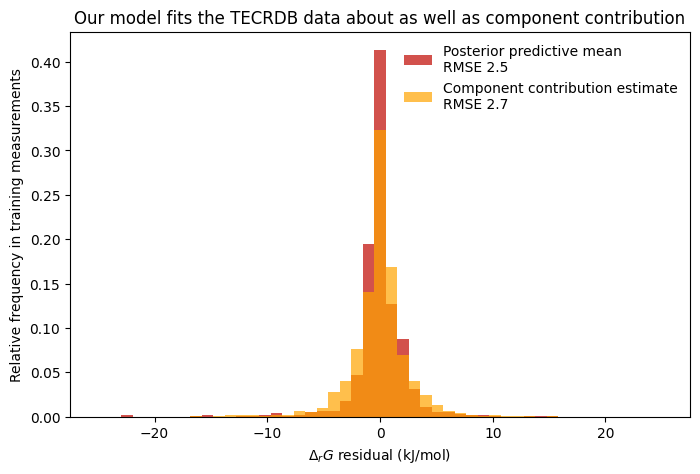

In [9]:
rmse_posterior = measurements[["resid_mean", "resid_cc"]].pow(2).mean().pipe(np.sqrt)

f, ax = plt.subplots(figsize=[8, 5])
bins = np.linspace(-25, 25, 50)
ax.hist(
    measurements["resid_mean"], 
    bins=bins, 
    alpha=0.7,
    density=True, 
    label=f"Posterior predictive mean\nRMSE {rmse_posterior['resid_mean'].round(1)}"
);
ax.hist(
    measurements["resid_cc"], 
    color="orange", bins=bins, 
    alpha=0.7, 
    density=True, 
    label=f"Component contribution estimate\nRMSE {rmse_posterior['resid_cc'].round(1)}"
);
ax.set(
    title="Our model fits the TECRDB data about as well as component contribution",
    ylabel="Relative frequency in training measurements",
    xlabel="$\Delta_rG$ residual (kJ/mol)"
);
ax.legend(frameon=False);
f.savefig(os.path.join(PLOTS_DIR, "in_sample_rmse_comparison.svg"), bbox_inches="tight");


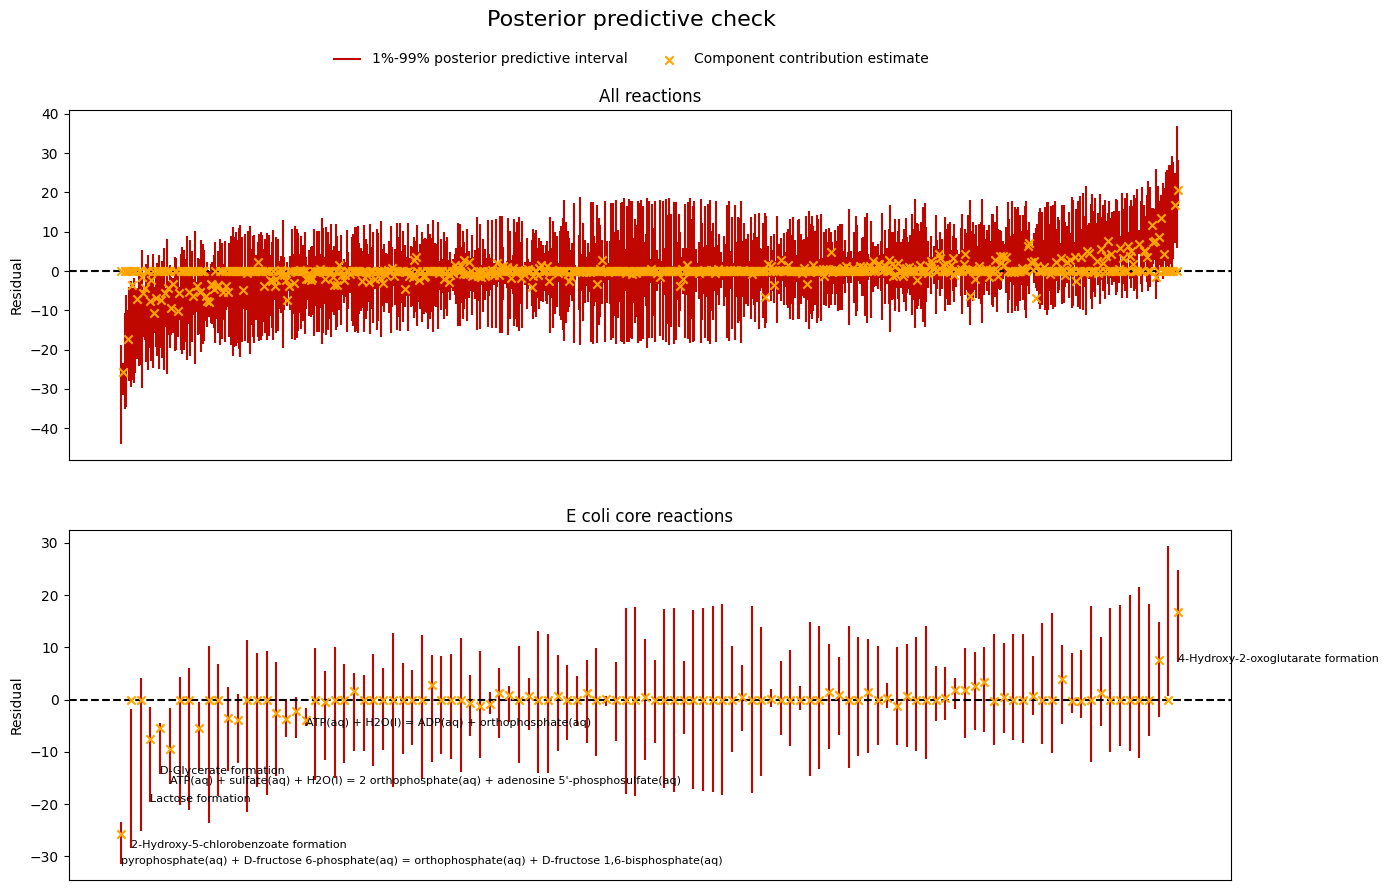

In [10]:
grouped = measurements.groupby("reaction_id")

measurements_by_reaction = (
    reactions[["is_e_coli_ccm", "description", "q0.01", "q0.5", "q0.99", "dgr_cc"]]
    .join(grouped.agg({"y": ["mean", "count"]})["y"].add_prefix("y_"))
    .assign(
        resid_low=lambda df: df["q0.01"] - df["y_mean"],
        resid_high=lambda df: df["q0.99"] - df["y_mean"],
        resid_med=lambda df: df["q0.5"] - df["y_mean"],
        resid_cc=lambda df: df["dgr_cc"] - df["y_mean"]
    )
)

f, axes = plt.subplots(2, 1, figsize=[15, 10])

for ccm_only, ax in zip([False, True], axes):
    plot_df = measurements_by_reaction.loc[lambda df: df["is_e_coli_ccm"]] if ccm_only else measurements_by_reaction
    plot_df = plot_df.sort_values("resid_med")
    x = np.linspace(*ax.get_xlim(), len(plot_df))
    vlines = ax.vlines(x, plot_df["resid_low"], plot_df["resid_high"], label="1%-99% posterior predictive interval");
    hline = ax.axhline(0, color="black", linestyle="--")
    scatter = ax.scatter(x, plot_df["resid_cc"], color="orange", zorder=2, marker="x", label="Component contribution");
    ax.set_xticks([])
    ax.set(
        title="E coli core reactions" if ccm_only else "All reactions",
        ylabel="Residual"
    )
    if ccm_only:
        for i, (ix, row) in enumerate(plot_df.iterrows()):
            if row["resid_low"] > 2 or row["resid_high"] < -1:
                ax.text(x[i], row["resid_low"], row["description"], fontsize=8)
f.legend(
    [vlines, scatter],
    ["1%-99% posterior predictive interval", "Component contribution estimate"], 
    frameon=False, 
    loc="upper center",
    bbox_to_anchor=[0.5, 0.95],
    ncol=2,
);
f.suptitle("Posterior predictive check", fontsize=16);

f.savefig(os.path.join(PLOTS_DIR, "marginal_ppc.svg"), bbox_inches="tight");


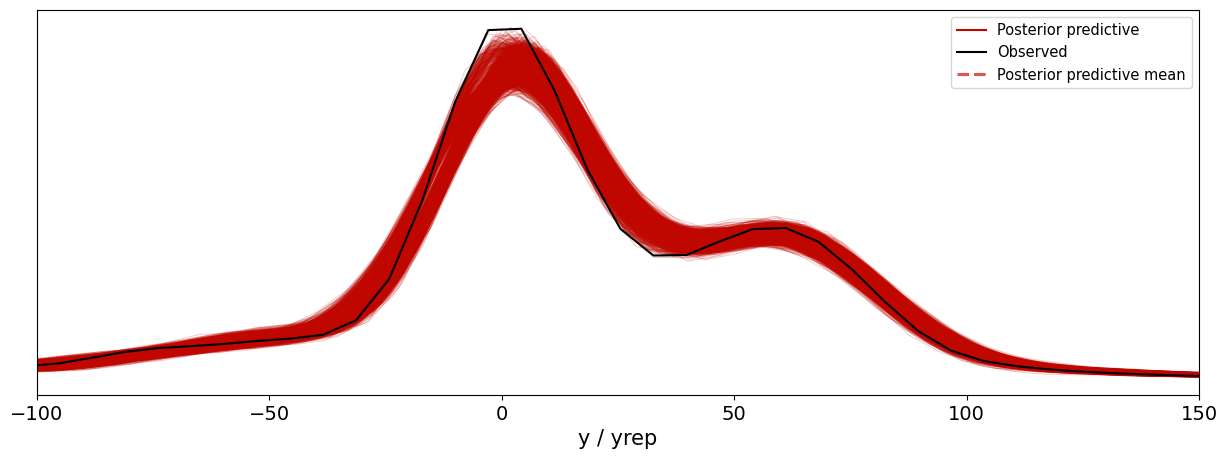

In [11]:
f, ax = plt.subplots(figsize=[15, 5])
az.plot_ppc(idata_c, data_pairs={"y": "yrep"}, var_names=["y"], ax=ax);
ax.set_xlim(-100, 150);
f.savefig(os.path.join(PLOTS_DIR, "ppc_kde.svg"), bbox_inches="tight");

## Plots of interesting parameters

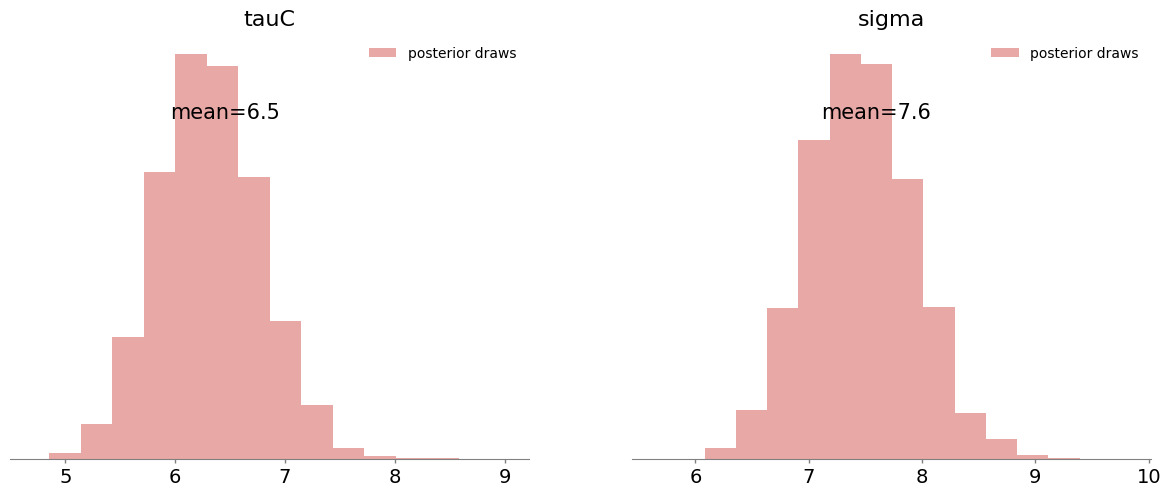

In [12]:
vars = ["tauC", "sigma"]
priors = {"tauC": [0, 4], "sigma": [0, 4]}

az.plot_posterior(idata_c, var_names=vars, kind="hist", label="posterior draws", hdi_prob="hide");

f = plt.gcf()
axes = f.get_axes()
for ax, var in zip(axes, vars):
    loc, scale = priors[var]
    dist = scipy.stats.norm(loc=loc, scale=scale).pdf(x)
    x = np.linspace(*ax.get_xlim(), 50)
    ax.legend(frameon=False)

f.savefig(os.path.join(PLOTS_DIR, "posteriors.svg"), bbox_inches="tight");

## Gaussian approximation of posterior distribution

These tables can be used if you would like a Gaussian approximation to the $\Delta_fG$ posterior distributions from our model.

In [13]:
mean = dgfC_draws.mean(dim=["chain", "draw"]).to_series().rename("mean")
cov = pd.DataFrame(np.cov(dgfC_draws.to_dataframe().unstack(["chain", "draw"])), index=compounds.index, columns=compounds.index)

mean.to_csv(os.path.join(INFERENCES_DIR, "gaussian_approximation_mean.csv"))
cov.to_csv(os.path.join(INFERENCES_DIR, "gaussian_approximation_cov.csv"))

ccm = compounds.loc[lambda df: df["is_e_coli_ccm"]].index.values

display(mean)
display(cov)

compound_id
5         -239.488424
6        -2812.706525
7           16.274609
8        -3087.771223
9        -3058.818770
             ...     
694320    -236.549825
694321     -36.950797
694322      77.345619
694323   -2201.343018
694324   -2183.007367
Name: mean, Length: 631, dtype: float64

compound_id,5,6,7,8,9,10,11,12,13,14,...,694315,694316,694317,694318,694319,694320,694321,694322,694323,694324
compound_id,,,,,,,,,,,,,,,,,,,,,
5,2.722699,-1.054210,-0.116563,-7.103201,-6.058782,-0.413908,-6.083919,1.933917,-5.070028,1.153141,...,-0.286016,-0.080371,0.043479,0.345881,-0.061191,-0.473786,0.220256,0.114964,-6.962822,-5.989239
6,-1.054210,14.748372,0.079844,16.190545,15.749964,11.529484,13.554123,1.847335,13.076372,4.791614,...,-0.011479,-0.150322,0.580874,-0.029520,-0.481919,0.038147,-0.597337,0.266758,12.783069,12.150352
7,-0.116563,0.079844,55.178921,0.997373,0.951604,-0.141820,1.210636,0.027185,0.954478,0.153793,...,-0.180759,1.398597,-0.025861,0.753287,0.631826,-0.294742,-0.309444,-1.530369,0.867671,0.328241
8,-7.103201,16.190545,0.997373,150.124524,147.033001,13.225259,130.521713,-4.818468,127.211434,-2.580547,...,-0.543365,0.015608,-1.150480,-0.476727,0.087237,5.293896,-3.359667,-0.687066,112.137570,109.295348
9,-6.058782,15.749964,0.951604,147.033001,145.719601,13.026776,127.750419,-3.993365,125.703183,-1.977508,...,-0.469404,-0.068713,-1.039912,-0.331565,-0.316927,5.102169,-2.911304,-0.407572,108.667759,107.042869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694320,-0.473786,0.038147,-0.294742,5.293896,5.102169,-0.202766,5.021635,-0.222144,4.892996,0.077606,...,2.410667,0.508244,-1.243719,2.315061,1.756723,29.258965,1.359427,-0.621257,4.918963,4.573611
694321,0.220256,-0.597337,-0.309444,-3.359667,-2.911304,-0.466895,-3.012803,0.186212,-2.650762,0.140730,...,0.667690,0.290638,2.494493,0.268148,-1.485800,1.359427,29.948081,0.535552,-2.387940,-2.046601
694322,0.114964,0.266758,-1.530369,-0.687066,-0.407572,0.288353,-0.264944,0.212155,-0.021068,0.364793,...,-0.990371,0.227510,-0.411921,-1.248370,0.320037,-0.621257,0.535552,56.559658,-0.132808,0.018609


In [14]:
print(f"Shape of formation energy covariance matrix: {cov.shape}")
print(f"Rank of component contribution formation energy covariance matrix: {np.linalg.matrix_rank(cc_cov)}")
print(f"Rank of new model formation energy covariance matrix: {np.linalg.matrix_rank(cov)}")

Shape of formation energy covariance matrix: (631, 631)
Rank of component contribution formation energy covariance matrix: 577
Rank of new model formation energy covariance matrix: 631


## Comparison with component contribution

First I wanted to find how many *E. coli* core reactions conserved chemical groups.

In [15]:
bad = reactions.loc[lambda df: df["conserves_groups"], ["description", "EC"]]

bad_e_coli_core =  reactions.loc[lambda df: df["conserves_groups"] & df["is_e_coli_ccm"], ["description", "EC"]]

display(len(bad))
display(bad_e_coli_core)

53

,description,EC
reaction_id,,
34,2'-deoxyinosine(aq) + adenine(aq) = 2'-deoxyad...,5.3.1.9
79,alpha-D-Glucose 6-phosphate(aq) = beta-D-Gluco...,2.7.4.3
162,UDPglucose(aq) = UDPgalactose(aq),1.6.1.1
210,"9-cis,12-cis-octadecadienoate(aq) = 9-cis,11-t...",2.7.4.3
211,all-trans-retinal(aq) = 11-cis-retinal(aq),2.7.4.3
295,thymidine(aq) + adenine(aq) = 2'-deoxyadenosin...,2.7.4.3
306,ATP(aq) + GDP(aq) = ADP(aq) + GTP(aq),4.2.1.11
315,L-glutamate(aq) = D-glutamate(aq),5.3.1.9
318,ATP(aq) + inosine 5'-diphosphate(aq) = ADP(aq)...,5.3.1.9


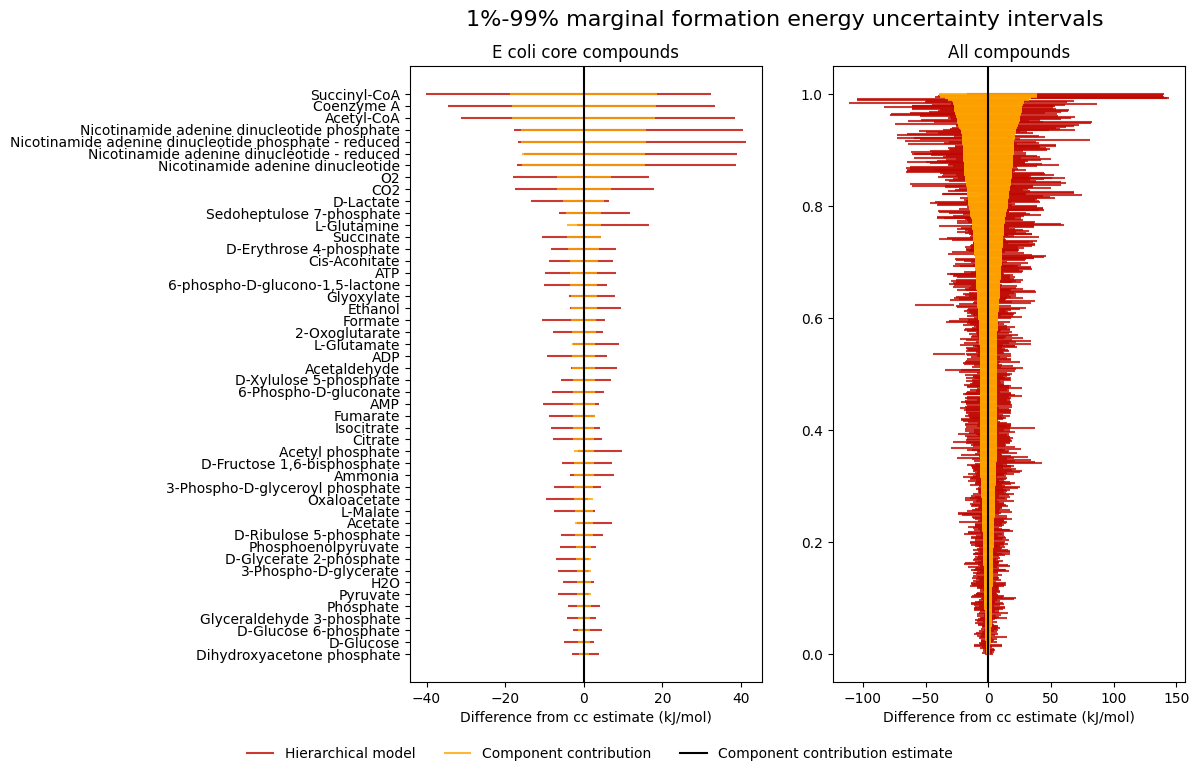

In [16]:
f, axes = plt.subplots(1, 2, figsize=[10, 8])
for ccm_only, ax in zip([True, False], axes):
    plot_df = compounds if not ccm_only else compounds.loc[lambda df: df["is_e_coli_ccm"]]
    plot_df = plot_df.sort_values("sd_cc")
    y = np.linspace(*ax.get_ylim(), len(plot_df))
    model_lines = ax.hlines(
        y,
        plot_df["q0.01"] - plot_df["dgf_cc"],
        plot_df["q0.99"] - plot_df["dgf_cc"],
        alpha=0.8,
    )
    cc_lines = ax.hlines(
        y, 
        plot_df["q0.01_cc"] - plot_df["dgf_cc"], 
        plot_df["q0.99_cc"] - plot_df["dgf_cc"],
        color="orange", 
        alpha=0.8,
    )
    equal_line = ax.axvline(0, color="black")
    if ccm_only:
        ticks = axes[0].set_yticks(y)
        txt = axes[0].set_yticklabels(plot_df["common_name"])
    ax.set(xlabel="Difference from cc estimate (kJ/mol)", title="E coli core compounds" if ccm_only else "All compounds")
leg = f.legend(
    [model_lines, cc_lines, equal_line],
    ["Hierarchical model", "Component contribution", "Component contribution estimate"],
    ncol=3,
    frameon=False,
    loc="lower center"
)
suptitle = f.suptitle("1%-99% marginal formation energy uncertainty intervals", fontsize=16, y=0.95)

f.savefig(os.path.join(PLOTS_DIR, "marginal_dgf_comparison.svg"), bbox_inches="tight");

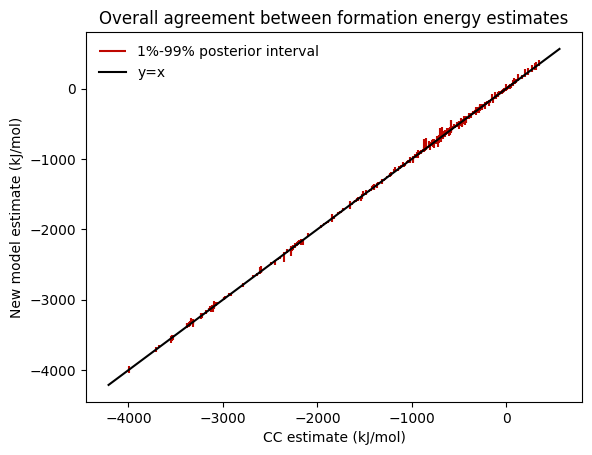

In [17]:
f, ax = plt.subplots()

ax.vlines(compounds["dgf_cc"], compounds["q0.01"], compounds["q0.99"], label="1%-99% posterior interval");
ax.plot([*ax.get_xlim()], [*ax.get_xlim()], color="black", label="y=x");
ax.set(
    title="Overall agreement between formation energy estimates",
    xlabel="CC estimate (kJ/mol)",
    ylabel="New model estimate (kJ/mol)"
)
ax.legend(frameon=False);
f.savefig(os.path.join(PLOTS_DIR, "dgf_comparison_scatter.svg"), bbox_inches="tight");

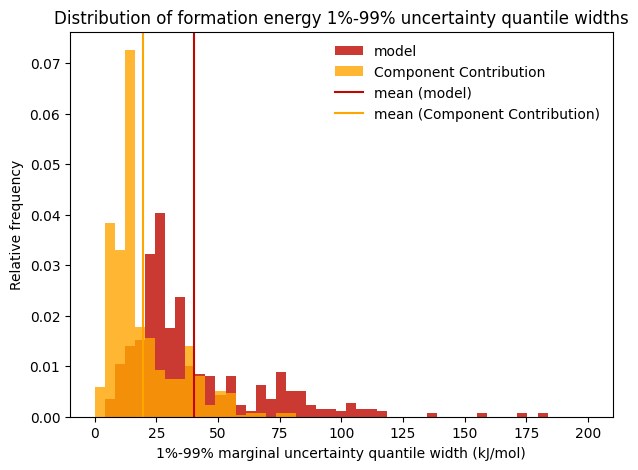

In [18]:
widths_model = compounds["q0.99"] - compounds["q0.01"]
widths_cc = compounds["q0.99_cc"] - compounds["q0.01_cc"]
med_model = widths_model.mean()
med_cc = widths_cc.mean()

f, ax = plt.subplots(figsize=[7, 5])
bins = np.linspace(0, 200, 50)
ax.set(
    title="Distribution of formation energy 1%-99% uncertainty quantile widths",
    ylabel="Relative frequency",
    xlabel="1%-99% marginal uncertainty quantile width (kJ/mol)"
)
ax.hist(widths_model, density=True, bins=bins, alpha=0.8, label="model");
ax.hist(widths_cc, color="orange", density=True, bins=bins, alpha=0.8, label="Component Contribution");
ax.axvline(med_model, label="mean (model)")
ax.axvline(med_cc, color="orange", label="mean (Component Contribution)")
ax.legend(frameon=False);
f.savefig(os.path.join(PLOTS_DIR, "marginal_width_hists.svg"), bbox_inches="tight");

# Out of sample case study

To see how the new model compares with component contribution when modelling unseen compounds, we constructed a custom test dataset.

The test dataset removes from the standard training dataset all reactions involving the compounds D-Glucose 6-phosphate, Phosphoenolpyruvate and Acetyl-CoA.

In [19]:
from dgfreg.component_contribution_replication import fit_component_contribution
excluded_compounds = [23, 70, 152]
excluded_reactions = (
    S
    .loc[excluded_compounds]
    .replace(0, np.nan)
    .stack()
    .reset_index()
    ["reaction_id"]
    .unique()
)
test_y = measurements.loc[lambda df: ~df["reaction_id"].isin(excluded_reactions)]
test_S = cc.predictor.params.train_S[test_y.index]
cc_test_fit = fit_component_contribution(test_S, G, test_y)

if "dgr_cc_test" in measurements.columns:
    measurements = measurements.drop("dgr_cc_test", axis=1)
measurements = measurements.join((S.T @ cc_test_fit.mu_dgf).rename("dgr_cc_test"), on="reaction_id")
measurements["resid_cc_test"] = measurements["dgr_cc_test"] - measurements["y"]

if "dgr_cc_test" in reactions.columns:
    reactions = reactions.drop("dgr_cc_test", axis=1)
reactions = reactions.join((S.T @ cc_test_fit.mu_dgf).rename("dgr_cc_test"), on="reaction_id")
reactions["resid_cc_test"] = reactions["dgr_cc_test"] - reactions["y_mean"]

In [20]:
test_y.shape, measurements.shape

((3629, 23), (3999, 25))

In [21]:
idata_test = az.from_json(os.path.join(INFERENCES_DIR, "equilibrator_custom_test", "idata.json"))
idata_test.posterior_predictive["yrep"] = idata_test.posterior_predictive["yrep"].rename({"observation": "reaction_id"})
idata_test.posterior_predictive.coords["reaction_id"] = idata_test.posterior_predictive.coords["reaction_id"] + 1

az.summary(idata_test, var_names=["tauC", "sigma", "mae"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tauC,6.993,0.519,6.024,7.971,0.024,0.017,463.0,913.0,1.00
sigma,6.994,0.516,6.040,7.943,0.027,0.019,375.0,917.0,1.01
mae,6.128,0.988,4.545,7.994,0.031,0.022,1078.0,1603.0,1.00


In [22]:
yrep_qs_test = idata_test.posterior_predictive["yrep"].quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("yrep_q").add_suffix("_test")
yrep_qs_test.index = yrep_qs_test.index.astype(int)
yrep_mean_test = idata_test.posterior_predictive["yrep"].mean(dim=["chain", "draw"])

resids_test = idata_test.posterior_predictive["yrep"] - reactions["y_mean"].values
resid_qs_test = resids_test.quantile([0.01, 0.5, 0.99], dim=["chain", "draw"]).to_series().unstack("quantile").add_prefix("resid_q").add_suffix("_test")
resid_qs_test.index = resid_qs_test.index.astype(int)
resid_qs_test = resid_qs_test.rename_axis("reaction_id")

if "yrep_q0.5_test" not in reactions.columns:
    reactions = reactions.join(yrep_qs_test)
if "resid_q0.5_test" not in reactions.columns:
    reactions = reactions.join(resid_qs_test)
reactions["yrep_mean_test"] = yrep_mean_test
reactions["resid_yrep_mean_test"] = reactions["yrep_mean_test"] - reactions["y_mean"]

if "yrep_mean_test" not in measurements.columns:
    measurements = measurements.join(reactions["yrep_mean_test"], on="reaction_id")
measurements["resid_yrep_mean_test"] = measurements["y"] - measurements["yrep_mean_test"]
rmse_test = measurements[["resid_cc_test", "resid_yrep_mean_test"]].drop(test_y.index).pow(2).mean().pipe(np.sqrt)
rmse_test

resid_cc_test           43.283757
resid_yrep_mean_test    21.917561
dtype: float64

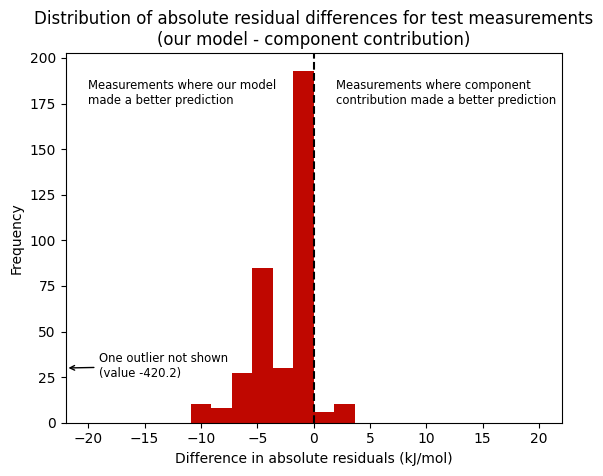

In [23]:
test_resid_diffs = (
    measurements[["resid_cc_test", "resid_yrep_mean_test"]]
    .drop(test_y.index)
    .abs()
    .diff(axis=1)
    ["resid_yrep_mean_test"]
)
outlier = test_resid_diffs.sort_values().iloc[0]

f, ax = plt.subplots()
bins = np.linspace(-20, 20, 23)
ax.hist(
    test_resid_diffs,
    bins=bins,
    label=""
);
ax.annotate(
    f"One outlier not shown\n(value {round(outlier, 1)})", 
    xy=[-22, 30],
    xytext=[-19, 25],
    arrowprops={"arrowstyle": "->"},
    fontsize="small"
);
ax.text(-20, 175, "Measurements where our model\nmade a better prediction", fontsize="small")
ax.text(2, 175, "Measurements where component\ncontribution made a better prediction", fontsize="small")
ax.axvline(0, color="black", linestyle="--")
ax.set(
    title="Distribution of absolute residual differences for test measurements\n(our model - component contribution)",
    ylabel="Frequency",
    xlabel="Difference in absolute residuals (kJ/mol)"
);
f.savefig(os.path.join(PLOTS_DIR, "out_of_sample_residual_hist.svg"), bbox_inches="tight");

In [24]:
dgfC_draws_test = idata_test.posterior["dgfC"]
cov_test = pd.DataFrame(np.cov(dgfC_draws_test.to_dataframe().unstack(["chain", "draw"])), index=compounds.index, columns=compounds.index)

print(f"Shape of formation energy covariance matrix: {cov_test.shape}")
print(f"Rank of new model formation energy covariance matrix when fit to test dataset: {np.linalg.matrix_rank(cov_test)}")
print(f"Rank of component contribution formation energy covariance matrix when fit to test dataset: {np.linalg.matrix_rank(cc_test_fit.cov_dgf)}")


Shape of formation energy covariance matrix: (631, 631)
Rank of new model formation energy covariance matrix when fit to test dataset: 631
Rank of component contribution formation energy covariance matrix when fit to test dataset: 575


<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
/var/folders/cf/th6yjfgn4yg_6497v9ml2y_80000gn/T/ipykernel_83592/2413824644.py:27: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel("$\Delta_rG$ residual (kJ/mol)")


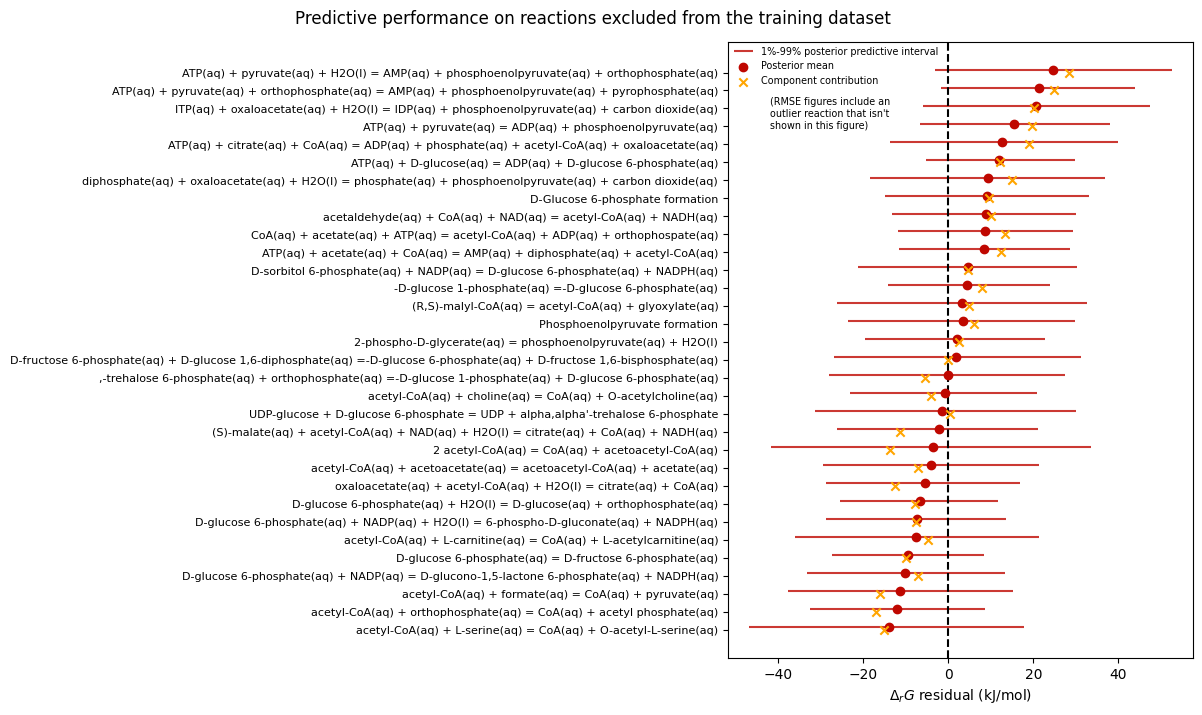

In [25]:
plot_df = reactions.loc[excluded_reactions].sort_values("resid_q0.5_test").iloc[:-1]
rmse_cc, rmse_new = rmse_test

f, ax = plt.subplots(figsize=[6, 8])
y = np.linspace(*ax.get_ylim(), len(plot_df))


# lines = ax.hlines(y-0.005, test_resid_qs_measurement.loc[ix, "q0.01"], test_resid_qs_measurement.loc[ix, "q0.99"])
red_lines = ax.hlines(y+0.005, plot_df["resid_q0.01_test"], plot_df["resid_q0.99_test"], alpha=0.8)
scatter_red = ax.scatter(plot_df["resid_yrep_mean_test"], y+0.005, zorder=3)

scatter_orange = ax.scatter(plot_df["resid_cc_test"], y, color="orange", marker="x", zorder=3)

ax.axvline(0, linestyle="--", color="black")
ax.set_yticks(y);
ax.set_yticklabels(plot_df["description"], fontsize=8);
# ax.set_xlabel("1%-99% posterior predictive interval: $\Delta_rG$ residual (kJ/mol)")
f.legend(
    [red_lines, scatter_red, scatter_orange],
    ["1%-99% posterior predictive interval", "Posterior mean", "Component contribution"],
    frameon=False, 
    # ncol=3, 
    bbox_to_anchor=[0.12, 0.885],
    fontsize="x-small",
    loc="upper left"
)
ax.set_xlabel("$\Delta_rG$ residual (kJ/mol)")
ax.text(-42, 0.9, "(RMSE figures include an\noutlier reaction that isn't\nshown in this figure)", fontsize="x-small")
f.suptitle("Predictive performance on reactions excluded from the training dataset", x=-0.1, y=0.92);

f.savefig(os.path.join(PLOTS_DIR, "out_of_sample_reaction_residuals.svg"), bbox_inches="tight");


## Figure that illustrates the main issue

This figure plots two reactions whose Gibbs energies are perfectly correlated in component contribution but not in our analysis

In [60]:
S = prepped.S.set_index(["compound_id", "reaction_id"])["stoichiometric_coefficient"].unstack().fillna(0)

G = prepped.G.set_index(["compound_id", "group_id"])["stoichiometric_coefficient"].unstack().fillna(0)

group_stoichiometry = S.T @ G
dup = group_stoichiometry.loc[lambda df: df.duplicated(keep=False)].join(reactions["description"]).set_index("description")
dup.loc[dup.eq(dup.loc["ATP(aq) + D-glucose(aq) = ADP(aq) + D-glucose 6-phosphate(aq)"]).all(axis=1)]

,(1+1)-ring =C< [H0 Z0 Mg0],-C [H3 Z0 Mg0],-C(-O)- [H2 Z0 Mg0],-C(=O)S- [H0 Z0 Mg0],-C- [H2 Z0 Mg0],-C-O [H3 Z0 Mg0],-C< [H1 Z0 Mg0],-C=O [H1 Z0 Mg0],-CO-OPO3 [H0 Z-2 Mg0],-COO [H0 Z-1 Mg0],...,ring >C< [H0 Z0 Mg0],ring >C=O [H0 Z0 Mg0],ring >c-N [H2 Z0 Mg0],ring >c-O [H0 Z-1 Mg0],ring >c-O [H1 Z0 Mg0],ring N-CO-N [H0 Z0 Mg0],ring nc(=n)n [H0 Z0 Mg0],secondary -Cl [H0 Z0 Mg0],secondary -Cl2 [H0 Z0 Mg0],two fused rings -N< [H0 Z0 Mg0]
description,,,,,,,,,,,,,,,,,,,,,
ATP(aq) + D-glucose(aq) = ADP(aq) + D-glucose 6-phosphate(aq),0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"ATP(aq) + D-fructose 6-phosphate(aq) = ADP(aq) + D-fructose 1,6-bisphosphate(aq)",0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
rids = [4, 20]

reactions.loc[rids].T

reaction_id,4,20
EC,2.7.1.1,2.7.1.11
is_formation,False,False
is_e_coli_ccm,False,True
description,ATP(aq) + D-glucose(aq) = ADP(aq) + D-glucose ...,ATP(aq) + D-fructose 6-phosphate(aq) = ADP(aq)...
reaction,kegg:C00002 + kegg:C00031 = kegg:C00008 + kegg...,kegg:C00002 + kegg:C00085 = kegg:C00008 + kegg...
conserves_groups,False,False
q0.01,15.881459,23.137578
q0.5,18.88465,27.0328
q0.99,21.994022,30.822352
resid_q0.01,-21.279787,-10.416174


In [89]:
rxn_cids = S[rids].loc[lambda df: (df != 0).any(axis=1)].index
pd.DataFrame(cov_gc, index=compounds.index, columns=compounds.index).loc[rxn_cids, rxn_cids]

compound_id,6,10,43,152,396,125172
compound_id,,,,,,
6,8.912493e-30,8.794890e-30,-4.939014e-31,1.039815e-31,-6.533320e-31,9.158519e-31
10,8.794890e-30,9.660173e-30,3.770250e-31,2.510142e-31,-2.144807e-30,4.272215e-31
43,-4.939014e-31,3.770250e-31,1.159286e-30,1.881528e-31,-1.345727e-30,-6.337941e-31
152,1.039815e-31,2.510142e-31,1.881528e-31,1.959473e-31,-2.568176e-31,-3.825508e-32
396,-6.533320e-31,-2.144807e-30,-1.345727e-30,-2.568176e-31,2.775005e-30,7.347018e-31
125172,9.158519e-31,4.272215e-31,-6.337941e-31,-3.825508e-32,7.347018e-31,5.523279e-31


In [82]:
cov_gc = cc.predictor.params.V_gc

dgr_gc_cov = pd.DataFrame(S.T.to_numpy() @ cov_gc @ S.to_numpy(), index=reactions.index, columns=reactions.index)
dgr_gc_cov.loc[rids, rids]

reaction_id,4,20
reaction_id,,
4,5.140262e-31,-2.504823e-31
20,-2.504823e-31,8.351264e-31
